# 05 Quantile forecasting using Gradient Boosted Trees

In [1]:
import sys
sys.executable

'/usr/local/bin/python'

## Imports

In [2]:
import re

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

import stock_utils.constants as cnst
import stock_utils.data as sd

pd.set_option('display.max_columns', None)

NSE_DATA_DIR = PosixPath('../data/NSE') | Valid: True
SCREENER_EPS_DATA_DIR = PosixPath('../data/Screener.in/EPS') | Valid: True
PROCESSED_DATA_DIR = PosixPath('../data/processed') | Valid: True


## Constants

In [3]:
QUANTILE_LB, QUANTILE_UB = 0.1, 0.9

stock_symbols = sd.get_all_stock_symbols(
    cnst.NSE_DATA_DIR
)

stock_symbols

['DEEPAKFERT', 'HDFCBANK', 'INDIGOPNTS', 'ITBEES', 'JUBLFOOD', 'NH']

In [4]:
STOCK_SYMBOL = stock_symbols[1]
STOCK_SYMBOL

'HDFCBANK'

## Loading stock data

In [5]:
stock_data = sd.StockData(STOCK_SYMBOL)
stock_data

Symbol: HDFCBANK
Total records: 1097
First record: 2020-01-01
Last record: 2024-05-09

## Modelling

### Target columns

In [6]:
target_cols = stock_data.standardized.filter(regex = "Target.*").columns.to_list()
target_cols

['Target 3D', 'Target 7D', 'Target 15D', 'Target 30D']

In [7]:
pred_input_df = stock_data.standardized.drop(columns = target_cols)
pred_input_df.shape

(1097, 43)

In [8]:
stock_data.standardized[target_cols].describe()

,Target 3D,Target 7D,Target 15D,Target 30D
count,1094.000000,1090.000000,1082.000000,1067.000000
mean,1.000856,1.002144,1.004490,1.009055
std,0.030511,0.045680,0.064045,0.087293
min,0.820000,0.718000,0.668000,0.629000
25%,0.986000,0.978000,0.968250,0.961000
50%,1.000000,1.002000,1.003500,1.008000
75%,1.016000,1.025000,1.041750,1.057000
max,1.178000,1.219000,1.231000,1.322000


### Data processing

In [9]:
def get_training_data(target_col: str):
    print(f"Target: {target_col}")
    X_df = stock_data.standardized[
        stock_data.standardized[target_col].notnull()
    ].drop(columns = target_cols).copy()
    y = stock_data.standardized[
        stock_data.standardized[target_col].notnull()
    ][target_col].copy()
    print(f"X.shape: {X_df.shape}")
    print(f"y.shape: {y.shape}")

    return X_df, y

### Grid search parameters

In [10]:
param_dict = {
    "n_estimators": [100, 125, 150],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [2, 3, 4],
    "max_features": ["log2", "sqrt", 0.25],
    "subsample": [0.75, 1.0]
}

feature_importances = pd.DataFrame(
    index = stock_data.standardized.drop(columns = target_cols).columns.to_list()
)

### Model building

In [11]:
def get_model():
    gb_model = GradientBoostingRegressor(
        loss = "squared_error",
        random_state = cnst.RANDOM_STATE
    )

    grid_cv = RandomizedSearchCV(
        gb_model,
        param_dict,
        n_iter = 12,
        cv = 5,
        n_jobs = -1,
        random_state = cnst.RANDOM_STATE
    )

    return grid_cv

def get_quantile_model(quantile: float):
    gb_model = GradientBoostingRegressor(
        loss = "quantile",
        alpha = quantile,
        random_state = cnst.RANDOM_STATE
    )

    grid_cv = RandomizedSearchCV(
        gb_model,
        param_dict,
        n_iter = 12,
        cv = 5,
        n_jobs = -1,
        random_state = cnst.RANDOM_STATE
    )

    return grid_cv

def print_results(y, preds):
    print(f"Target std: {y.std():.3f}")
    print(f"R2: {r2_score(y, preds):.3f}")
    print(f"MSE: {root_mean_squared_error(y, preds):.3f}")
    print(f"MAE: {mean_absolute_error(y, preds):.3f}")

## Training

### `Target 3D`

#### Forecasting model

In [12]:
target_col = target_cols[0]
X, y = get_training_data(target_col)

Target: Target 3D
X.shape: (1094, 43)
y.shape: (1094,)


In [13]:
model = get_model()
model.fit(X, y)
model.best_params_

{'subsample': 0.75,
 'n_estimators': 100,
 'max_features': 'sqrt',
 'max_depth': 3,
 'learning_rate': 0.05}

In [14]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score').iloc[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.433430,0.116599,0.008434,0.004387,0.75,100,sqrt,3,0.05,"{'subsample': 0.75, 'n_estimators': 100, 'max_...",-0.155930,-0.063717,-0.048037,-0.000814,-0.070219,-0.067744,0.050333,1
4,0.394748,0.081823,0.006445,0.001548,1.0,125,sqrt,2,0.1,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",-0.216774,-0.143655,-0.044157,-0.012950,-0.186421,-0.120791,0.079429,2
2,0.453334,0.093747,0.006493,0.001643,1.0,100,log2,4,0.05,"{'subsample': 1.0, 'n_estimators': 100, 'max_f...",-0.186417,-0.178978,-0.083481,-0.049049,-0.140687,-0.127723,0.053642,3
11,0.548809,0.023370,0.005205,0.001448,0.75,150,sqrt,4,0.05,"{'subsample': 0.75, 'n_estimators': 150, 'max_...",-0.147570,-0.220888,-0.132832,-0.005533,-0.156681,-0.132701,0.070349,4
8,0.685927,0.099328,0.008081,0.003448,1.0,125,sqrt,4,0.05,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",-0.182005,-0.177359,-0.081841,-0.049608,-0.284861,-0.155135,0.083130,5


In [15]:
feature_importances = feature_importances.join(
    pd.DataFrame(
        model.best_estimator_.feature_importances_,
        index = model.best_estimator_.feature_names_in_,
        columns = [target_col]
    )
)

preds = model.predict(X)
print_results(y, preds)

Target std: 0.031
R2: 0.405
MSE: 0.024
MAE: 0.018


#### Lower quantile model

In [16]:
lb_model = get_quantile_model(QUANTILE_LB)
lb_model.fit(X, y)
lb_model.best_params_

{'subsample': 0.75,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Upper quantile model

In [17]:
ub_model = get_quantile_model(QUANTILE_UB)
ub_model.fit(X, y)
ub_model.best_params_

{'subsample': 0.75,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Predictions

In [18]:
pred_col_name = f'Pred {target_col}'
lb_col_name, ub_col_name = f'LB {target_col}', f'UB {target_col}'

stock_data.processed[pred_col_name] = (model.predict(pred_input_df) * stock_data.processed['Close']).round(2)

stock_data.processed[lb_col_name] = (lb_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[lb_col_name] = stock_data.processed[[lb_col_name, pred_col_name]].min(axis = 1)

stock_data.processed[ub_col_name] = (ub_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[ub_col_name] = stock_data.processed[[ub_col_name, pred_col_name]].max(axis = 1)

stock_data.processed[['Date', 'Close', target_col, pred_col_name, lb_col_name, ub_col_name]].dropna().iloc[-10:, :]

,Date,Close,Target 3D,Pred Target 3D,LB Target 3D,UB Target 3D
1084,2024-04-22,1512.20,1510.75,1511.61,1484.35,1539.19
1085,2024-04-23,1507.60,1509.80,1507.77,1474.27,1533.27
1086,2024-04-24,1511.70,1529.50,1508.51,1480.16,1536.77
1087,2024-04-25,1510.75,1520.10,1511.32,1482.60,1536.00
1088,2024-04-26,1509.80,1532.25,1509.03,1480.79,1535.53
1089,2024-04-29,1529.50,1519.60,1527.58,1502.18,1550.36
1090,2024-04-30,1520.10,1522.65,1518.73,1492.14,1549.68
1091,2024-05-02,1532.25,1506.15,1526.99,1504.33,1558.00
1092,2024-05-03,1519.60,1482.65,1514.06,1484.93,1540.90
1093,2024-05-06,1522.65,1447.50,1515.64,1490.18,1539.78


### `Target 7D`

#### Forecasting model

In [19]:
target_col = target_cols[1]
X, y = get_training_data(target_col)

Target: Target 7D
X.shape: (1090, 43)
y.shape: (1090,)


In [20]:
model = get_model()
model.fit(X, y)
model.best_params_

{'subsample': 0.75,
 'n_estimators': 100,
 'max_features': 'sqrt',
 'max_depth': 3,
 'learning_rate': 0.05}

In [21]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score').iloc[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.366363,0.042469,0.005463,0.000954,0.75,100,sqrt,3,0.05,"{'subsample': 0.75, 'n_estimators': 100, 'max_...",-0.119515,-0.400534,-0.152372,-0.100025,-0.135154,-0.181520,0.110863,1
8,0.591165,0.060097,0.009745,0.007054,1.0,125,sqrt,4,0.05,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",-0.287846,-0.596167,-0.178882,-0.220382,-0.095192,-0.275694,0.171967,2
2,0.462293,0.036914,0.006761,0.001535,1.0,100,log2,4,0.05,"{'subsample': 1.0, 'n_estimators': 100, 'max_f...",-0.320172,-0.611054,-0.244962,-0.160365,-0.048015,-0.276914,0.190011,3
4,0.465318,0.063682,0.006315,0.002788,1.0,125,sqrt,2,0.1,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",-0.301298,-0.537580,-0.159147,-0.202548,-0.250508,-0.290216,0.132479,4
1,0.556461,0.035127,0.005386,0.000126,0.75,125,sqrt,3,0.1,"{'subsample': 0.75, 'n_estimators': 125, 'max_...",-0.164467,-0.723294,-0.340520,-0.159759,-0.286395,-0.334887,0.206376,5


In [22]:
feature_importances = feature_importances.join(
    pd.DataFrame(
        model.best_estimator_.feature_importances_,
        index = model.best_estimator_.feature_names_in_,
        columns = [target_col]
    )
)

preds = model.predict(X)
print_results(y, preds)

Target std: 0.046
R2: 0.509
MSE: 0.032
MAE: 0.024


#### Lower quantile model

In [23]:
lb_model = get_quantile_model(QUANTILE_LB)
lb_model.fit(X, y)
lb_model.best_params_

{'subsample': 1.0,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Upper quantile model

In [24]:
ub_model = get_quantile_model(QUANTILE_UB)
ub_model.fit(X, y)
ub_model.best_params_

{'subsample': 0.75,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Predictions

In [25]:
pred_col_name = f'Pred {target_col}'
lb_col_name, ub_col_name = f'LB {target_col}', f'UB {target_col}'

stock_data.processed[pred_col_name] = (model.predict(pred_input_df) * stock_data.processed['Close']).round(2)

stock_data.processed[lb_col_name] = (lb_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[lb_col_name] = stock_data.processed[[lb_col_name, pred_col_name]].min(axis = 1)

stock_data.processed[ub_col_name] = (ub_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[ub_col_name] = stock_data.processed[[ub_col_name, pred_col_name]].max(axis = 1)

stock_data.processed[['Date', 'Close', target_col, pred_col_name, lb_col_name, ub_col_name]].dropna().iloc[-10:, :]

,Date,Close,Target 7D,Pred Target 7D,LB Target 7D,UB Target 7D
1080,2024-04-15,1494.70,1510.75,1488.17,1459.52,1511.42
1081,2024-04-16,1509.25,1509.80,1496.89,1461.99,1526.85
1082,2024-04-18,1494.70,1529.50,1492.61,1457.10,1534.95
1083,2024-04-19,1531.30,1520.10,1524.42,1460.34,1569.79
1084,2024-04-22,1512.20,1532.25,1514.67,1470.32,1560.15
1085,2024-04-23,1507.60,1519.60,1507.50,1473.48,1540.48
1086,2024-04-24,1511.70,1522.65,1512.25,1473.70,1533.24
1087,2024-04-25,1510.75,1506.15,1513.09,1488.89,1554.89
1088,2024-04-26,1509.80,1482.65,1504.61,1481.20,1538.64
1089,2024-04-29,1529.50,1447.50,1522.58,1448.44,1554.21


### `Target 15D`

#### Forecasting model

In [26]:
target_col = target_cols[2]
X, y = get_training_data(target_col)

Target: Target 15D
X.shape: (1082, 43)
y.shape: (1082,)


In [27]:
model = get_model()
model.fit(X, y)
model.best_params_

{'subsample': 1.0,
 'n_estimators': 100,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.05}

In [28]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score').iloc[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.390921,0.063028,0.005465,0.000586,1.0,100,log2,4,0.05,"{'subsample': 1.0, 'n_estimators': 100, 'max_f...",-0.168862,-0.165742,-0.506187,-0.166523,-0.170976,-0.235658,0.135277,1
8,0.569634,0.084091,0.005742,0.000607,1.0,125,sqrt,4,0.05,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",-0.261569,-0.044235,-0.582047,-0.153047,-0.211198,-0.250419,0.180905,2
10,0.376296,0.069804,0.005395,0.000850,0.75,100,sqrt,3,0.05,"{'subsample': 0.75, 'n_estimators': 100, 'max_...",-0.159670,-0.338451,-0.474246,-0.227392,-0.086869,-0.257326,0.136473,3
4,0.347463,0.046705,0.007756,0.002121,1.0,125,sqrt,2,0.1,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",-0.264373,-0.375331,-0.428156,-0.227135,-0.157877,-0.290574,0.098420,4
9,0.657854,0.049481,0.006381,0.001815,1.0,150,log2,4,0.1,"{'subsample': 1.0, 'n_estimators': 150, 'max_f...",-0.321195,0.029445,-0.836249,-0.245636,-0.252349,-0.325197,0.282346,5


In [29]:
feature_importances = feature_importances.join(
    pd.DataFrame(
        model.best_estimator_.feature_importances_,
        index = model.best_estimator_.feature_names_in_,
        columns = [target_col]
    )
)

preds = model.predict(X)
print_results(y, preds)

Target std: 0.064
R2: 0.785
MSE: 0.030
MAE: 0.024


#### Lower quantile model

In [30]:
lb_model = get_quantile_model(QUANTILE_LB)
lb_model.fit(X, y)
lb_model.best_params_

{'subsample': 0.75,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Upper quantile model

In [31]:
ub_model = get_quantile_model(QUANTILE_UB)
ub_model.fit(X, y)
ub_model.best_params_

{'subsample': 1.0,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Predictions

In [32]:
pred_col_name = f'Pred {target_col}'
lb_col_name, ub_col_name = f'LB {target_col}', f'UB {target_col}'

stock_data.processed[pred_col_name] = (model.predict(pred_input_df) * stock_data.processed['Close']).round(2)

stock_data.processed[lb_col_name] = (lb_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[lb_col_name] = stock_data.processed[[lb_col_name, pred_col_name]].min(axis = 1)

stock_data.processed[ub_col_name] = (ub_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[ub_col_name] = stock_data.processed[[ub_col_name, pred_col_name]].max(axis = 1)

stock_data.processed[['Date', 'Close', target_col, pred_col_name, lb_col_name, ub_col_name]].dropna().iloc[-10:, :]

,Date,Close,Target 15D,Pred Target 15D,LB Target 15D,UB Target 15D
1072,2024-04-02,1480.15,1510.75,1473.69,1410.52,1539.25
1073,2024-04-03,1482.30,1509.80,1480.34,1409.97,1547.61
1074,2024-04-04,1527.60,1529.50,1511.36,1438.10,1580.44
1075,2024-04-05,1549.55,1520.10,1523.30,1458.24,1597.81
1076,2024-04-08,1546.60,1532.25,1513.64,1458.54,1584.85
1077,2024-04-09,1548.55,1519.60,1508.96,1460.87,1574.83
1078,2024-04-10,1536.35,1522.65,1504.00,1448.59,1563.62
1079,2024-04-12,1518.95,1506.15,1507.82,1437.18,1565.05
1080,2024-04-15,1494.70,1482.65,1500.01,1439.70,1556.21
1081,2024-04-16,1509.25,1447.50,1502.49,1447.27,1553.22


### `Target 30D`

#### Forecasting model

In [33]:
target_col = target_cols[3]
X, y = get_training_data(target_col)

Target: Target 30D
X.shape: (1067, 43)
y.shape: (1067,)


In [34]:
model = get_model()
model.fit(X, y)
model.best_params_

{'subsample': 0.75,
 'n_estimators': 125,
 'max_features': 0.25,
 'max_depth': 3,
 'learning_rate': 0.1}

In [35]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score').iloc[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.639209,0.070681,0.006901,0.001565,0.75,125,0.25,3,0.1,"{'subsample': 0.75, 'n_estimators': 125, 'max_...",0.077948,0.218623,-1.016044,-0.452212,-0.168577,-0.268052,0.438149,1
9,0.615140,0.057191,0.007118,0.002138,1.0,150,log2,4,0.1,"{'subsample': 1.0, 'n_estimators': 150, 'max_f...",0.026599,0.382102,-1.374664,-0.505356,0.064255,-0.281413,0.616435,2
10,0.343275,0.034552,0.006000,0.001651,0.75,100,sqrt,3,0.05,"{'subsample': 0.75, 'n_estimators': 100, 'max_...",-0.011873,0.242741,-1.164650,-0.500963,-0.068625,-0.300674,0.493786,3
8,0.595366,0.103828,0.007171,0.002751,1.0,125,sqrt,4,0.05,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",-0.023092,0.210819,-1.155927,-0.367786,-0.168973,-0.300992,0.467329,4
2,0.373871,0.013017,0.005337,0.000321,1.0,100,log2,4,0.05,"{'subsample': 1.0, 'n_estimators': 100, 'max_f...",-0.034130,0.298682,-1.313110,-0.555401,0.026556,-0.315481,0.570293,5


In [36]:
feature_importances = feature_importances.join(
    pd.DataFrame(
        model.best_estimator_.feature_importances_,
        index = model.best_estimator_.feature_names_in_,
        columns = [target_col]
    )
)

preds = model.predict(X)
print_results(y, preds)

Target std: 0.087
R2: 0.923
MSE: 0.024
MAE: 0.019


#### Lower quantile model

In [37]:
lb_model = get_quantile_model(QUANTILE_LB)
lb_model.fit(X, y)
lb_model.best_params_

{'subsample': 1.0,
 'n_estimators': 150,
 'max_features': 0.25,
 'max_depth': 4,
 'learning_rate': 0.1}

#### Upper quantile model

In [38]:
ub_model = get_quantile_model(QUANTILE_UB)
ub_model.fit(X, y)
ub_model.best_params_

{'subsample': 1.0,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Predictions

In [39]:
pred_col_name = f'Pred {target_col}'
lb_col_name, ub_col_name = f'LB {target_col}', f'UB {target_col}'

stock_data.processed[pred_col_name] = (model.predict(pred_input_df) * stock_data.processed['Close']).round(2)

stock_data.processed[lb_col_name] = (lb_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[lb_col_name] = stock_data.processed[[lb_col_name, pred_col_name]].min(axis = 1)

stock_data.processed[ub_col_name] = (ub_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[ub_col_name] = stock_data.processed[[ub_col_name, pred_col_name]].max(axis = 1)

stock_data.processed[['Date', 'Close', target_col, pred_col_name, lb_col_name, ub_col_name]].dropna().iloc[-10:, :]

,Date,Close,Target 30D,Pred Target 30D,LB Target 30D,UB Target 30D
1057,2024-03-07,1446.10,1510.75,1515.12,1400.01,1521.96
1058,2024-03-11,1427.80,1509.80,1496.82,1394.57,1510.23
1059,2024-03-12,1459.55,1529.50,1516.69,1418.52,1530.12
1060,2024-03-13,1460.40,1520.10,1515.58,1420.48,1533.10
1061,2024-03-14,1455.45,1532.25,1521.75,1418.73,1532.41
1062,2024-03-15,1452.65,1519.60,1507.66,1398.33,1525.54
1063,2024-03-18,1446.05,1522.65,1505.79,1422.14,1524.92
1064,2024-03-19,1449.35,1506.15,1506.06,1391.81,1522.25
1065,2024-03-20,1431.05,1482.65,1500.47,1381.76,1512.71
1066,2024-03-21,1445.75,1447.50,1497.23,1385.39,1524.58


## Feature importances

In [40]:
feature_importances['Mean'] = feature_importances.mean(axis = 1)
(feature_importances.sort_values('Mean', ascending = False) * 100).round(1)

,Target 3D,Target 7D,Target 15D,Target 30D,Mean
52W H,9.6,7.1,8.2,9.9,8.7
Range 60MA,6.0,10.3,6.8,11.2,8.6
DayOfYear,3.3,8.8,7.2,13.3,8.2
PE,3.0,6.0,8.7,14.4,8.0
52W L,1.8,5.0,5.5,8.1,5.1
Range 30MA,3.5,5.0,4.5,6.4,4.9
VWAP 60MA,6.4,4.3,3.2,4.4,4.6
Close 60MA,5.2,2.8,6.3,1.2,3.9
Month,1.9,2.4,5.7,3.9,3.5
Range 15MA,2.5,2.5,5.1,2.9,3.2


## Forecasts

In [41]:
stock_data.processed.filter(regex = "(Date)|(Close$)|(Pred.*)").iloc[-10:, :]

,Date,Close,Pred Target 3D,Pred Target 7D,Pred Target 15D,Pred Target 30D
1087,2024-04-25,1510.75,1511.32,1513.09,1498.29,1515.68
1088,2024-04-26,1509.80,1509.03,1504.61,1494.91,1518.17
1089,2024-04-29,1529.50,1527.58,1522.58,1491.09,1492.69
1090,2024-04-30,1520.10,1518.73,1518.26,1498.33,1510.57
1091,2024-05-02,1532.25,1526.99,1522.25,1492.03,1509.18
1092,2024-05-03,1519.60,1514.06,1513.50,1495.34,1529.50
1093,2024-05-06,1522.65,1515.64,1512.20,1500.72,1535.95
1094,2024-05-07,1506.15,1508.90,1503.59,1514.29,1567.44
1095,2024-05-08,1482.65,1485.37,1489.88,1494.03,1574.11
1096,2024-05-09,1447.50,1449.89,1458.44,1492.42,1537.49


Date: 2024-05-09
Close: 1447.5
Target 3D: 1449.89 (1430.69 to 1492.25)
Target 7D: 1458.44 (1441.88 to 1498.5)
Target 15D: 1492.42 (1433.81 to 1524.05)
Target 30D: 1537.49 (1463.15 to 1552.29)


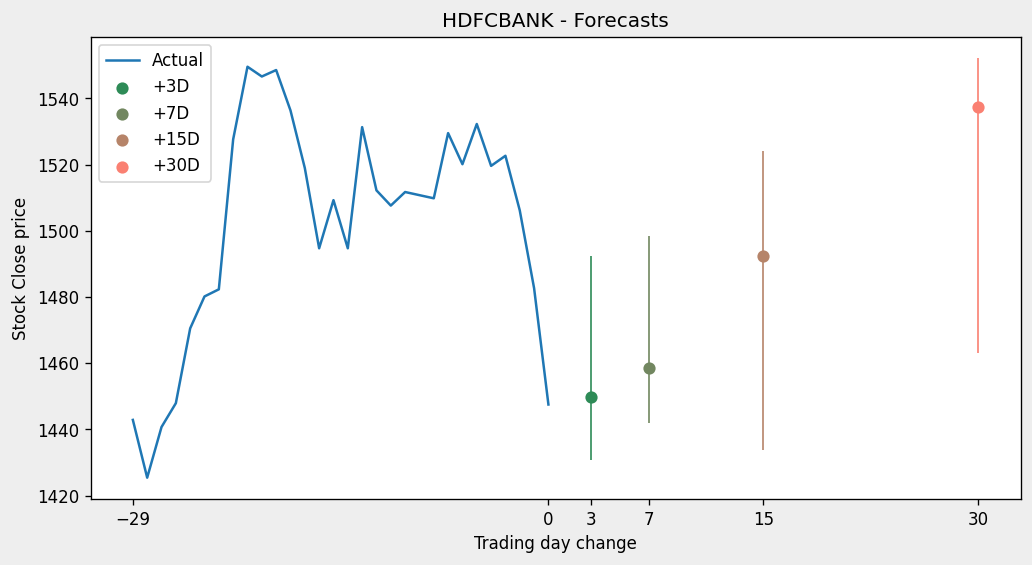

In [42]:
plt.figure(figsize = (10, 5), dpi = 120, facecolor = "#eee")

plt.plot(
    range(-29, 1), 
    stock_data.processed['Close'].iloc[-30:], 
    label = "Actual"
)

latest_preds = stock_data.processed.iloc[-1]
print(f"Date: {latest_preds['Date'].date()}")
print(f"Close: {latest_preds['Close']}")

color_palette = sns.color_palette("blend:seagreen,salmon", n_colors = len(target_cols))
xticks = [-29, 0]

for i, target_col in enumerate(target_cols):
    print(f"{target_col}: {latest_preds[f'Pred {target_col}']}", end = " ")
    print(f"({latest_preds[f'LB {target_col}']} to {latest_preds[f'UB {target_col}']})")
    
    target_day = int(re.search("\d+", target_col)[0])
    xticks.append(target_day)

    plt.scatter(
        target_day, 
        latest_preds[f'Pred {target_col}'],
        color = color_palette[i],
        s = 40,
        label = f"+{target_day}D"
    )
    plt.vlines(
        x = target_day,
        ymin = latest_preds[f'LB {target_col}'],
        ymax = latest_preds[f'UB {target_col}'],
        linewidth = 1,
        colors = color_palette[i]
    )

plt.xlabel("Trading day change")
plt.ylabel("Stock Close price")
plt.title(f"{STOCK_SYMBOL} - Forecasts")
plt.xticks(xticks)
plt.legend()
plt.show()